In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras import initializers
from keras.layers import Dropout, Activation, Embedding, Convolution1D, MaxPooling1D, Input, Dense, Merge, \
                         BatchNormalization, Flatten, Reshape, Concatenate
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers

In [3]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web

In [3]:
style.use('ggplot')

start = dt.datetime(2011, 1, 1)
end = dt.datetime(2017, 10,31)

In [4]:
RIL = web.DataReader('RELIANCE.BO', "yahoo", start, end)


In [5]:
RIL.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-25,940.000000,945.750000,930.000000,939.950012,939.950012,448754.0
2017-10-26,938.349976,958.200012,931.500000,947.250000,947.250000,694575.0
2017-10-27,950.099976,956.500000,926.400024,929.450012,929.450012,4100930.0
2017-10-30,931.000000,945.000000,931.000000,940.150024,940.150024,435289.0
2017-10-31,943.000000,945.000000,932.099976,940.799988,940.799988,476464.0


In [10]:
RIL.to_csv('Reliance1.csv')

In [6]:
df = pd.read_csv('Reliance1.csv', parse_dates=True, index_col=0)

In [7]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,531.000000,533.200012,526.099976,529.125000,459.736267,756798.0
2011-01-04,530.000000,539.400024,528.075012,538.275024,467.686401,1848602.0
2011-01-05,538.775024,545.000000,535.075012,538.275024,467.686401,2359952.0
2011-01-06,539.825012,544.500000,536.674988,542.000000,470.922852,1369672.0
2011-01-07,540.500000,543.799988,529.049988,532.450012,462.625244,1161154.0


In [13]:
#visualize the data
##plot the stocks' Open price, For the legend, use label parameter and plt.legend()

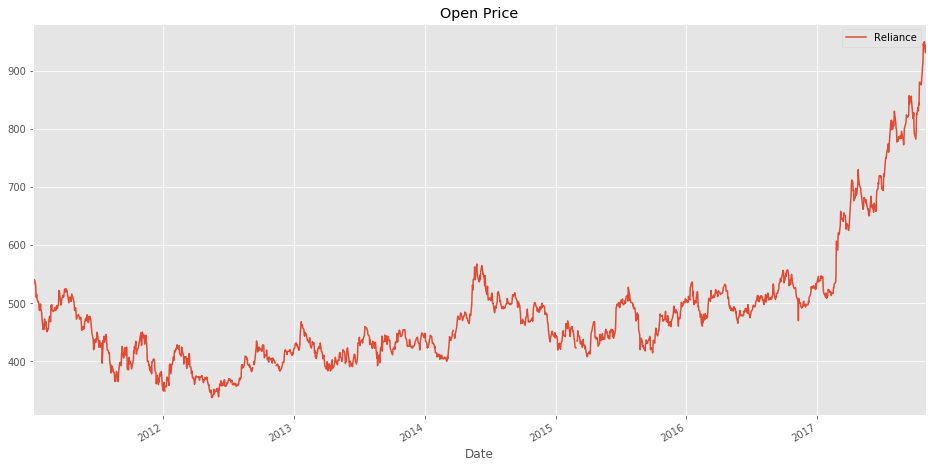

In [8]:
RIL['Open'].plot(label='Reliance',figsize=(16,8),title='Open Price')
plt.legend()
plt.show();

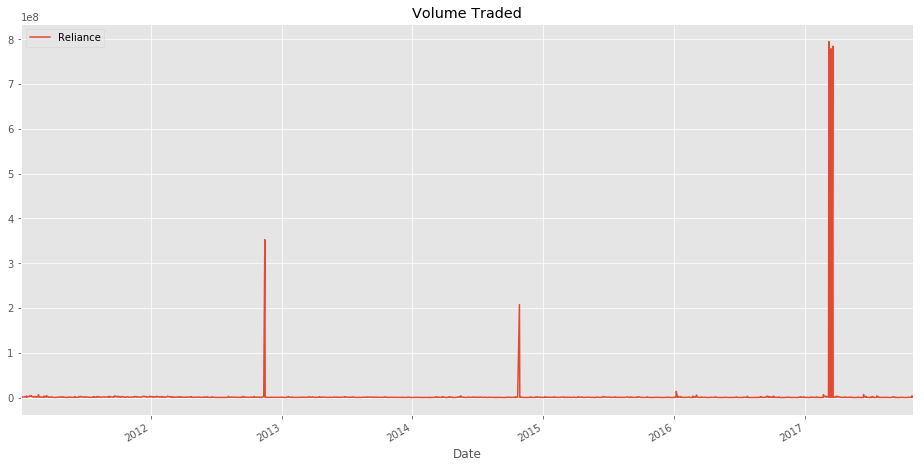

In [9]:
#Plot the Volume of stock traded each day.
RIL['Volume'].plot(label='Reliance',figsize=(16,8),title='Volume Traded')
plt.legend()
plt.show();

In [16]:
#Interesting, looks like reliance had a really big spike somewhere in  2017. 
#What was the date of this maximum trading volume for Reliance?
#What happened that day? 

In [10]:
RIL['Volume'].argmax()

Timestamp('2017-03-09 00:00:00')

In [107]:
#What happened that day? 
# http://www.moneycontrol.com/news/business/companies/reliance-jios-grand-plan-capture-halfmarket-by-2021-1059355.html

#Mar 09, 2017 05:23 PM IST | Source: Moneycontrol.com
#Reliance Jio's grand plan: Capture half the market by 2021

In [ ]:
# we are going with the  total market cap of the company,
#instead of the stock price or the volume traded.

# Create a new column for each dataframe called "Total Traded" which is the
# Open Price multiplied by the Volume Traded.

In [11]:
RIL['Total Traded'] = RIL['Open']*RIL['Volume']

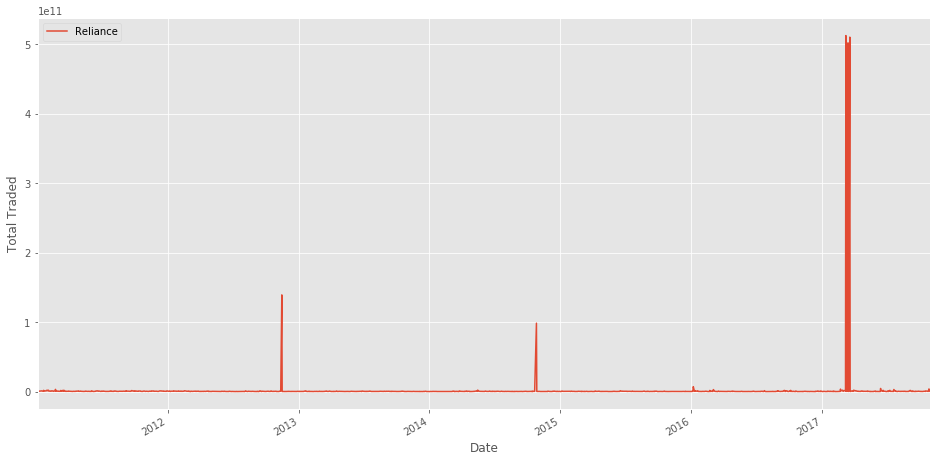

In [12]:
#Plot this "Total Traded" against the time index.
RIL['Total Traded'].plot(label='Reliance',figsize=(16,8))
plt.legend()
plt.ylabel('Total Traded')
plt.show();

In [13]:
RIL['Total Traded'].argmax()

Timestamp('2017-03-09 00:00:00')

In [ ]:
#huge amount of money traded for Reliance in 'March 2017

In [ ]:
#plotting out some MA (Moving Averages). Plot out the MA50 and MA200 for Reliance.

In [14]:
RIL['MA50'] = RIL['Open'].rolling(50).mean()
RIL['MA200'] = RIL['Open'].rolling(200).mean()

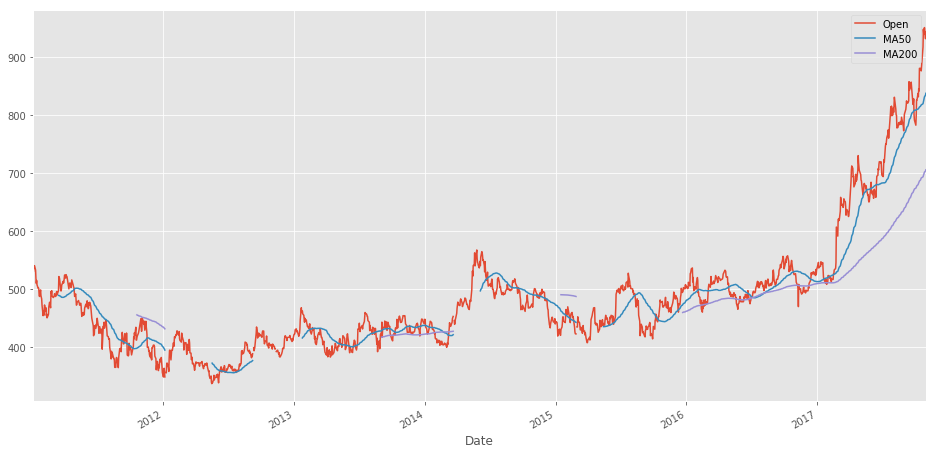

In [15]:
RIL[['Open','MA50','MA200']].plot(label='Reliance',figsize=(16,8))
plt.show();

In [ ]:
#Create a CandleStick chart for Reliance in March 2017
#(too many dates won't look good for a candlestick chart)

In [19]:
from matplotlib.finance import candlestick_ohlc
from matplotlib.dates import DateFormatter, date2num, WeekdayLocator, DayLocator, MONDAY

In [20]:
# Rest the index to get a column of January Dates
RIL_reset = RIL.loc['2017-03':'2017-03'].reset_index()

In [21]:
# Create a new column of numerical "date" values for matplotlib to use
RIL_reset['date_ax'] = RIL_reset['Date'].apply(lambda date: date2num(date))
RIL_values = [tuple(vals) for vals in RIL_reset[['date_ax', 'Open', 'High', 'Low', 'Close']].values]

In [22]:
mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
alldays = DayLocator()              # minor ticks on the days
weekFormatter = DateFormatter('%b %d')  # e.g., march 17
dayFormatter = DateFormatter('%d')      # e.g., 17


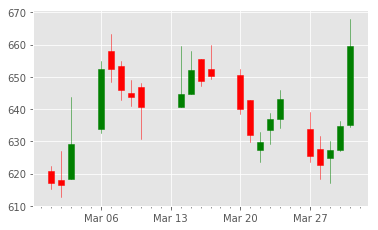

In [23]:
fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)
ax.xaxis.set_major_locator(mondays)
ax.xaxis.set_minor_locator(alldays)
ax.xaxis.set_major_formatter(weekFormatter)

candlestick_ohlc(ax, RIL_values, width=0.6, colorup='g',colordown='r');
plt.show();

In [ ]:
# Financial Analysis

#Create a new column for each dataframe called returns. 
#This column will be calculated from the Close price column.
#There are two ways to do this, either a simple calculation using the .shift() method 
#that follows the formula above, or you can also use pandas' built in pct_change method. 

In [ ]:
#Daily Percentage Change
#First we will begin by calculating the daily percentage change. 
#Daily percentage change is defined by the following formula:

#rt=(todayprice/previousdayprice)-1

#This defines r_t (return at time t) as equal to the price at time t divided by the price at 
#time t-1 (the previous day) minus 1.Basically this just informs you of your percent gain
#(or loss) if you bought the stock on day and then sold it the next day.
#While this isn't necessarily helpful for attempting to predict future values of the stock, 
#its very helpful in analyzing the volatility of the stock. If daily returns have a wide distribution, 
#the stock is more volatile from one day to the next.Let's calculate the percent returns and then plot 
#them with a histogram, and decide which stock is the most stable!

In [24]:
# Method 1: Using shift
RIL['returns'] = (RIL['Close'] / RIL['Close'].shift(1) ) - 1

In [25]:
RIL.tail()

,Open,High,Low,Close,Adj Close,Volume,Total Traded,MA50,MA200,returns
Date,,,,,,,,,,
2017-10-25,940.000000,945.750000,930.000000,939.950012,939.950012,448754.0,4.218288e+08,824.597501,697.343002,0.005563
2017-10-26,938.349976,958.200012,931.500000,947.250000,947.250000,694575.0,6.517544e+08,827.385001,699.324377,0.007766
2017-10-27,950.099976,956.500000,926.400024,929.450012,929.450012,4100930.0,3.896293e+09,830.838000,701.344502,-0.018791
2017-10-30,931.000000,945.000000,931.000000,940.150024,940.150024,435289.0,4.052541e+08,833.893000,703.317002,0.011512
2017-10-31,943.000000,945.000000,932.099976,940.799988,940.799988,476464.0,4.493056e+08,837.021500,705.343752,0.000691


In [26]:
RIL['returns'] = RIL['Close'].pct_change(1)

In [27]:
RIL.tail()

,Open,High,Low,Close,Adj Close,Volume,Total Traded,MA50,MA200,returns
Date,,,,,,,,,,
2017-10-25,940.000000,945.750000,930.000000,939.950012,939.950012,448754.0,4.218288e+08,824.597501,697.343002,0.005563
2017-10-26,938.349976,958.200012,931.500000,947.250000,947.250000,694575.0,6.517544e+08,827.385001,699.324377,0.007766
2017-10-27,950.099976,956.500000,926.400024,929.450012,929.450012,4100930.0,3.896293e+09,830.838000,701.344502,-0.018791
2017-10-30,931.000000,945.000000,931.000000,940.150024,940.150024,435289.0,4.052541e+08,833.893000,703.317002,0.011512
2017-10-31,943.000000,945.000000,932.099976,940.799988,940.799988,476464.0,4.493056e+08,837.021500,705.343752,0.000691


In [ ]:
#Now plot a histogram of the return to view the volatilty of the stocks.

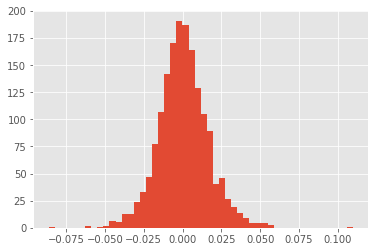

In [28]:
RIL['returns'].hist(bins=50)
plt.show()


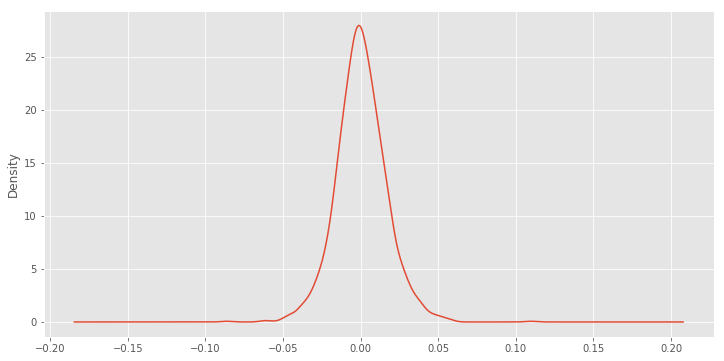

In [29]:
#plotting a KDE instead of histogram to ggain another view point
RIL['returns'].plot(kind='kde',label='Reliance',figsize=(12,6))
plt.show()

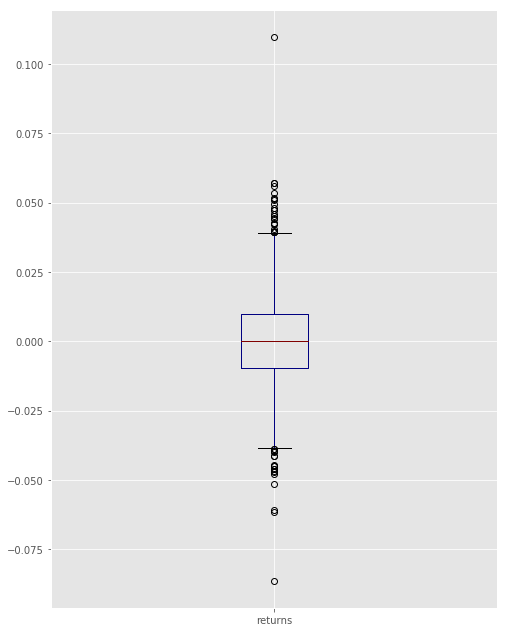

In [30]:
RIL['returns'].plot(kind='box',figsize=(8,11),colormap='jet')
plt.show();

In [31]:
#Cumulative Daily Returns
RIL['Cumulative Return'] = (1 + RIL['returns']).cumprod()

In [32]:
RIL.tail()

,Open,High,Low,Close,Adj Close,Volume,Total Traded,MA50,MA200,returns,Cumulative Return
Date,,,,,,,,,,,
2017-10-25,940.000000,945.750000,930.000000,939.950012,939.950012,448754.0,4.218288e+08,824.597501,697.343002,0.005563,1.776423
2017-10-26,938.349976,958.200012,931.500000,947.250000,947.250000,694575.0,6.517544e+08,827.385001,699.324377,0.007766,1.790220
2017-10-27,950.099976,956.500000,926.400024,929.450012,929.450012,4100930.0,3.896293e+09,830.838000,701.344502,-0.018791,1.756579
2017-10-30,931.000000,945.000000,931.000000,940.150024,940.150024,435289.0,4.052541e+08,833.893000,703.317002,0.011512,1.776801
2017-10-31,943.000000,945.000000,932.099976,940.799988,940.799988,476464.0,4.493056e+08,837.021500,705.343752,0.000691,1.778030


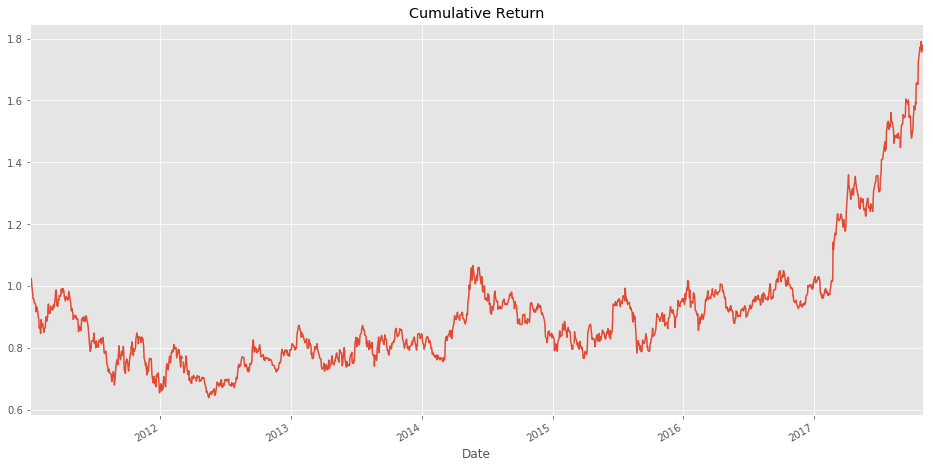

In [33]:
RIL['Cumulative Return'].plot(label='RIL',figsize=(16,8),title='Cumulative Return')
plt.show()

In [34]:
RIL.isnull().sum()

Open                    6
High                    6
Low                     6
Close                   6
Adj Close               6
Volume                  6
Total Traded            6
MA50                  330
MA200                1010
returns                 7
Cumulative Return       7
dtype: int64

In [22]:
dj = pd.read_csv("rel_stock.csv")
news = pd.read_csv("relnews.csv")

In [23]:
news.tail()

,Date,News
127245,13-06-12 0:00,"IIP: Slowdown continues to be pervasive, says ..."
127246,13-06-12 0:00,Fortis diagnostic arm SRL to get Rs 370 cr PE ...
127247,13-06-12 0:00,Cairn agrees Â£400m bid for North Sea explorer
127248,13-06-12 0:00,RComm unit wins Singapore IPO approval
127249,13-06-12 0:00,Yahoo and CNBC form content partnership


In [ ]:
#dj['Date']=pd.to_datetime(dj.Date)

In [14]:
news.shape

(127250, 2)

In [24]:
#df.plot()
#plt.show()
dj.head()

,Date,close,adj close
0,16-06-12,361.983327,616008.6667
1,17-06-12,360.666667,600575.3333
2,18-06-12,359.350006,585142.0000
3,19-06-12,368.625000,829710.0000
4,20-06-12,368.799988,591690.0000


In [25]:
news=news.groupby('Date').sum()
#news=pd.DataFrame({'News' : news.groupby( [ "Date"] ).sum()}).reset_index()


In [27]:

news.News[0]

'JK Tyre turns profitable in Q3 on improved demand'

In [28]:
news=news.reset_index()

In [29]:
news.head()

,Date,News
0,01-01-13,JK Tyre turns profitable in Q3 on improved demand
1,01-01-13 0:00,Costly ride: Cars to get expensive in 2013Indi...
2,01-01-14,"GST will add 2% to GDP, co to save on logistic..."
3,01-01-14 0:00,Bullion association to join UCX-led bid for MC...
4,01-01-15,"Delhi gets new land pooling policy, will price..."


In [30]:
# Compare the number of unique dates. We want matching values.
print(len(set(dj.Date)))
print(len(set(news.Date)))



1983
1823


In [31]:
print(dj.shape)
print(news.shape)


(1983, 3)
(1823, 2)


In [33]:
dj1=dj[['Date','close','adj close']]

In [34]:
dj1.head()

,Date,close,adj close
0,16-06-12,361.983327,616008.6667
1,17-06-12,360.666667,600575.3333
2,18-06-12,359.350006,585142.0000
3,19-06-12,368.625000,829710.0000
4,20-06-12,368.799988,591690.0000


In [35]:
news['Date']=pd.to_datetime(news.Date)

In [36]:
news.sort_values(by='Date',ascending=True).head()

,Date,News
32,2012-01-07,"M&M, Toyota sales rev up in June; Tata Motors ..."
37,2012-01-08,"Reserve money up 6.7% in week to July 27, says..."
42,2012-01-09,"JSW Steel, JSW Ispat merger ratio at 1:72TVS M..."
48,2012-01-10,Applaud Chidu initiatives but cheer awaits det...
53,2012-01-11,Hyundai invests &#36;300 million in India manu...


In [37]:
news= news[news.Date.isin(dj1.Date)]

In [38]:
news.head()

,Date,News
0,2013-01-01,JK Tyre turns profitable in Q3 on improved demand
1,2013-01-01,Costly ride: Cars to get expensive in 2013Indi...
2,2014-01-01,"GST will add 2% to GDP, co to save on logistic..."
3,2014-01-01,Bullion association to join UCX-led bid for MC...
4,2015-01-01,"Delhi gets new land pooling policy, will price..."


In [39]:
news.shape

(1820, 2)

In [37]:
#news = pd.merge(news, dj1, how='inner', on=['Date'])
#news= news[news.Date.isin(dj.Date)]
#df_yes = dj1[dj1['Date'].isin(news.Date)]
#df_no = df[~df['zip'].isin(keep)]

In [39]:
# Calculate the difference in opening prices between the following and current day.
# The model will try to predict how much the Open value will change beased on the news.
#dj1 = dj1.set_index('Date').diff(periods=1)
#dj1['Date'] = dj1.index
#dj1 = dj1.reset_index(drop=True)
# Remove unneeded features

#dj = dj.drop(['High','Low','Close','Adj Close','Volume'], 1)

In [44]:
#news[news.Date==date]['News']


In [40]:

# Create a list of the opening prices and their corresponding daily headlines from the news
close = []
adj =[]
headlines = []
DateNew=[]
for row in dj.iterrows():
    daily_headlines = []
    daily_date=[]
    daily_close=[]
    daily_adj=[]
    date = row[1]['Date']
    close.append(row[1]['close'])
    adj.append(row[1]['adj close'])
    
    for row_ in news[news.Date==date].iterrows():
        daily_headlines.append(row_[1]['News'])
        daily_date.append(row_[1]['Date'])
        #daily_close.append(row_[1]['Close'])
        #daily_adj.append(row_[1]['Adj Close'])
    # Track progress
    headlines.append(daily_headlines)
    DateNew.append(daily_date)
    #close.append(daily_close)
    #adj.append(daily_adj)
    if len(close) % 500 == 0:
        print(len(close))

500
1000
1500


In [47]:
#headlines=pd.DataFrame(headlines)
#price=pd.DataFrame(price)
#DateNew=pd.DataFrame(DateNew)

In [50]:
headlines[3]


["BHEL to set up fabrication unit in BhandaraBharti Softbank, Yahoo Japan form JVRBI committee advises risk based supervision for banksCCI penalty may send guilty in frenzy of appeal: TrilegalHPCL stops fuel supply to Kingfisher, resumes post paymentsGMR allots Rs 100-cr NCDs to ICICI BankONGC, CNPC sign agreement to jointly explore oil and gasVodafone cuts 3G rates by up to 80%Can't pay 'extremely high' price for spectrum, says UninorAdvance tax collection in Q1 up 5% at Rs 33089crDLF in talks with 4 entities for sale of wind biz: SourcesGAAR panel to finalise report by August-endAI executive pilots want management to end pilots strikeNPCIL identifies four new sites for nuclear power plantsGovt to release 5 MT of foodgrains, 3 MT wheatDS Group enters powdered soft drink marketCaptain Media plans to launch 24hr news channel in AugustAvendus Capital ropes in ex-Japanese ministerChart of the day: Why government needs to sow seeds for agri revolutionEnd blame game; govt, RBI, ind can work

In [51]:
# Compare lengths to ensure they are the same
print(len(close))
print(len(adj))
print(len(headlines))
print(len(DateNew))

1983
1983
1983
1983


In [52]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [53]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [87]:
# Clean the headlines
clean_headlines = []

for daily_headlines in headlines:
    clean_daily_headlines = []
    for headline in daily_headlines:
        clean_daily_headlines.append(clean_text(headline))
    clean_headlines.append(clean_daily_headlines)

AttributeError: 'NaTType' object has no attribute 'lower'

In [56]:
# Take a look at some headlines to ensure everything was cleaned well
clean_headlines[3]

['bhel set fabrication unit bhandarabharti softbank yahoo japan form jvrbi committee advises risk based supervision bankscci penalty may send guilty frenzy appeal trilegalhpcl stops fuel supply kingfisher resumes post paymentsgmr allots rs 100 cr ncds icici bankongc cnpc sign agreement jointly explore oil gasvodafone cuts 3g rates 80 pay extremely high price spectrum says uninoradvance tax collection q1 5 rs 33089crdlf talks 4 entities sale wind biz sourcesgaar panel finalise report august endai executive pilots want management end pilots strikenpcil identifies four new sites nuclear power plantsgovt release 5 mt foodgrains 3 mt wheatds group enters powdered soft drink marketcaptain media plans launch 24hr news channel augustavendus capital ropes ex japanese ministerchart day government needs sow seeds agri revolutionend blame game govt rbi ind work one subbaraotelenor signals india cut permit cost soarsfdi india declines 41 36 1 85bn aprilseamless transit highway toll plazas 2014india

In [57]:
# Find the number of times each word was used and the size of the vocabulary
word_counts = {}

for date in clean_headlines:
    for headline in date:
        for word in headline.split():
            if word not in word_counts:
                word_counts[word] = 1
            else:
                word_counts[word] += 1
            
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 21647


In [59]:
# Load GloVe's embeddings
embeddings_index = {}
with open('glove.840B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))

Word embeddings: 94


In [60]:
df = pd.DataFrame({'Date':DateNew,'Close':close,'Adj_Close':adj,'News':headlines})

In [61]:
df.head()

,Adj_Close,Close,Date,News
0,616008.6667,361.983327,[2012-06-16 00:00:00],[State Bank of India plans up to &#36;2bn offs...
1,600575.3333,360.666667,[2012-06-17 00:00:00],[No obligation in contract on production targe...
2,585142.0000,359.350006,[2012-06-18 00:00:00],[Fuel price adjustment needed to curb demand: ...
3,829710.0000,368.625000,[2012-06-19 00:00:00],[BHEL to set up fabrication unit in BhandaraBh...
4,591690.0000,368.799988,[2012-06-20 00:00:00],"[Fed twists again, extending stimulus to weak ..."


In [62]:
# Remove top row since it has a null value.
df = df[df.Date.notnull()]
df=df[df.Close.notnull()]
df=df[df.Adj_Close.notnull()]

In [63]:
df.isnull().sum()

Adj_Close    0
Close        0
Date         0
News         0
dtype: int64

In [64]:
df=df[df.astype(str)['Date'] != '[]']

In [65]:
df.head()

,Adj_Close,Close,Date,News
0,616008.6667,361.983327,[2012-06-16 00:00:00],[State Bank of India plans up to &#36;2bn offs...
1,600575.3333,360.666667,[2012-06-17 00:00:00],[No obligation in contract on production targe...
2,585142.0000,359.350006,[2012-06-18 00:00:00],[Fuel price adjustment needed to curb demand: ...
3,829710.0000,368.625000,[2012-06-19 00:00:00],[BHEL to set up fabrication unit in BhandaraBh...
4,591690.0000,368.799988,[2012-06-20 00:00:00],"[Fed twists again, extending stimulus to weak ..."


In [66]:
df=df[['Date','Close','Adj_Close','News']]

In [67]:

df = df.reset_index(drop=True)
df.head()

,Date,Close,Adj_Close,News
0,[2012-06-16 00:00:00],361.983327,616008.6667,[State Bank of India plans up to &#36;2bn offs...
1,[2012-06-17 00:00:00],360.666667,600575.3333,[No obligation in contract on production targe...
2,[2012-06-18 00:00:00],359.350006,585142.0000,[Fuel price adjustment needed to curb demand: ...
3,[2012-06-19 00:00:00],368.625000,829710.0000,[BHEL to set up fabrication unit in BhandaraBh...
4,[2012-06-20 00:00:00],368.799988,591690.0000,"[Fed twists again, extending stimulus to weak ..."


In [86]:
df.News[4]

["Fed twists again, extending stimulus to weak economyGovt must smoothen path for foreign investors: LN MittalTCS to pay Rs 8-cr commission to Ratan Tata for FY12DGCA asks airlines to slash fares in highest fare bucketAviation sector needs tax reforms, not mere FDI: ReportNickelodeon to launch branded mobile handsets for kidsCable TV digitalisation deadline put off by four monthsI-T probe into political parties, trusts to check evasionMetro, IKEA chiefs may meet Sharma in Russia this weekRBI issues guidelines to set up White Label ATMsPMO may decide on 58 captive coal blocks this weekKansai Nerolac to buy 68% stake in Nepalese paint makerSBI to reduce lending rates to exporters soonWorld steel output up 0.7% at 131m tonnes in MayGovt to exempt 14 more services from taxRIM launches Rs 1.39 lakh phone, says will outgrow industryIndia's unrestricted foreign debt limits see good demandCable digitisation deadline may be extended by 3-4 monthsHC asks Unitech to respond to plea of TelenorVeda

In [62]:
# Compare the number of headlines for each day
#print(max(len(i) for i in headlines))
#print(min(len(i) for i in headlines))
#print(np.mean(len(i) for i in headlines))

In [84]:
df['News']=df['News'].apply(lambda x:','.join(str(x) for x in df['News']))

MemoryError: 

In [74]:
df['Date']=pd.to_datetime(df.Date.apply(lambda x: x[0]))

In [75]:
df.head()

,Date,Close,Adj_Close,News
0,2012-06-16,361.983327,616008.6667,[State Bank of India plans up to &#36;2bn offs...
1,2012-06-17,360.666667,600575.3333,[No obligation in contract on production targe...
2,2012-06-18,359.350006,585142.0000,[Fuel price adjustment needed to curb demand: ...
3,2012-06-19,368.625000,829710.0000,[BHEL to set up fabrication unit in BhandaraBh...
4,2012-06-20,368.799988,591690.0000,"[Fed twists again, extending stimulus to weak ..."


In [77]:

df=df.set_index('Date')

In [78]:
df.head()

,Close,Adj_Close,News
Date,,,
2012-06-16,361.983327,616008.6667,[State Bank of India plans up to &#36;2bn offs...
2012-06-17,360.666667,600575.3333,[No obligation in contract on production targe...
2012-06-18,359.350006,585142.0000,[Fuel price adjustment needed to curb demand: ...
2012-06-19,368.625000,829710.0000,[BHEL to set up fabrication unit in BhandaraBh...
2012-06-20,368.799988,591690.0000,"[Fed twists again, extending stimulus to weak ..."


In [79]:
# Saving the data as pickle file
df.to_pickle('Upickled_ten_year_filtered_data.pkl')  

In [80]:
# Save pandas frame in csv form
df.to_csv('sample_interpolated_df_10_years_filtered_data.csv',
                       sep='\t', encoding='utf-8')

In [81]:
# Reading the data as pickle file
dataframe_read = pd.read_pickle('Upickled_ten_year_filtered_data.pkl')

In [76]:
df4["compound"] = ''
df4["neg"] = ''
df4["neu"] = ''
df4["pos"] = ''

In [77]:
df4.head()
                  

,Open,compound,neg,neu,pos
Date,,,,,
2011-01-03,531.000000,,,,
2011-01-04,530.000000,,,,
2011-01-06,539.825012,,,,
2011-01-07,540.500000,,,,
2011-01-13,515.000000,,,,


In [78]:
df3.T

Date,2011-01-03 00:00:00,2011-01-04 00:00:00,2011-01-06 00:00:00,2011-01-07 00:00:00,2011-01-13 00:00:00,2011-01-18 00:00:00,2011-01-19 00:00:00,2011-01-20 00:00:00,2011-01-21 00:00:00,2011-01-24 00:00:00,...,2017-09-29 00:00:00,2017-10-03 00:00:00,2017-10-04 00:00:00,2017-10-05 00:00:00,2017-10-10 00:00:00,2017-10-13 00:00:00,2017-10-17 00:00:00,2017-10-18 00:00:00,2017-10-23 00:00:00,2017-10-26 00:00:00
Open,531,530,539.825,540.5,515,502.35,500,489.225,487.5,498.725,...,791,782.15,798.35,825,831,880,878.9,875.55,916.7,938.35
News,Speaking at FICCI's 83rd Annual General Meetin...,I won’t be too enthused on the stock beyond Rs...,Faced with a gas crunch at its petrochemical p...,It has been a series of positive days for the ...,"Buy Reliance Industries on dips, says Ambarees...",Reliance Industries (RIL) is planning global h...,"Jai Bala, Chief Market Technician, cashthechao...","The flagship company of Reliance Group, Relian...","The flagship company of Reliance Group, Relian...","Bharti Airtel stronger than Reliance, says Ani...",...,Reliance chairman Mukesh Ambani's son Akash sa...,"In the Budget, there was a proposal by the Fin...",Sandeep Wagle of powermywealth.com is of the v...,Ashwani Gujral of ashwanigujral.com recommends...,Nifty on Tuesday was trading in the green up 2...,Operational performance was far better than an...,RIL-BP combine yesterday submitted to the Dire...,Prabhudas Lilladher recommended accumulate rat...,Sharekhan is bullish on Reliance Industries ha...,The partners yesterday submitted to the Direct...


In [79]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

In [80]:
df.loc[3]['News']

"It has been a series of positive days for the markets, until the closing on the last day of the week. However, it is not the time to reach the panic button yet, says CNBC-TV18’s Udayan Mukherjee.The Central Bureau of Investigation (CBI) searched the house of a former upstream regulator on Friday, the first investigative action after the CAG said in a report there may have been inflated costs for some of Reliance Industries' exploration activities.Reliance Industries touched an intraday high of Rs 906 and an intraday low of Rs 875.60. At 12:37 hrs the share was quoting at Rs 876.90, down Rs 20.70, or 2.31%."

In [81]:
sid = SentimentIntensityAnalyzer()
for date,row in df3.T.iteritems():
    try:
        sentence = unicodedata.normalize('NFKD', df3.loc[date,'News'])
        ss = sid.polarity_scores(sentence)
        df4.set_value(date, 'compound', ss['compound'])
        df4.set_value(date, 'neg', ss['neg'])
        df4.set_value(date, 'neu', ss['neu'])
        df4.set_value(date, 'pos', ss['pos'])
    except TypeError:
        print (df3.loc[date,'News'])
        print (date)

In [82]:
df4.head()

,Open,compound,neg,neu,pos
Date,,,,,
2011-01-03,531.000000,0.4404,0,0.943,0.057
2011-01-04,530.000000,0.25,0,0.947,0.053
2011-01-06,539.825012,-0.0516,0.069,0.876,0.055
2011-01-07,540.500000,0.34,0.049,0.872,0.079
2011-01-13,515.000000,0,0,1,0


In [83]:
datasetNorm = (df4 - df4.mean()) / (df4.max() - df4.min())
datasetNorm.reset_index(inplace=True)
del datasetNorm['Date']
datasetNorm['next_prices'] = datasetNorm['Open'].shift(-1)
datasetNorm.head(5)

,Open,compound,neg,neu,pos,next_prices
0,0.098656,0.0576869,-0.100587,0.130353,-0.0579471,0.096992
1,0.096992,-0.0402605,-0.100587,0.141222,-0.068876,0.113344
2,0.113344,-0.195413,0.158812,-0.0517124,-0.0634115,0.114467
3,0.114467,0.00603816,0.0836239,-0.062582,0.00216224,0.072027
4,0.072027,-0.168868,-0.100587,0.285244,-0.213685,0.050974


In [84]:
num_epochs = 100

batch_size = 1

total_series_length = len(datasetNorm.index)

truncated_backprop_length = 3 #The size of the sequence

state_size = 12 #The number of neurons

num_features = 4
num_classes = 1 #[1,0]

num_batches = total_series_length//batch_size//truncated_backprop_length

min_test_size = 100

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 1160
The current configuration gives us 386 batches of 1 observations each one looking 3 steps in the past


In [85]:
datasetTrain = datasetNorm[datasetNorm.index < num_batches*batch_size*truncated_backprop_length]


for i in range(min_test_size,len(datasetNorm.index)):
    
    if(i % truncated_backprop_length*batch_size == 0):
        test_first_idx = len(datasetNorm.index)-i
        break

datasetTest =  datasetNorm[datasetNorm.index >= test_first_idx]

In [86]:
xTrain = datasetTrain[['Open','neu','neg','pos']].as_matrix()
yTrain = datasetTrain['next_prices'].as_matrix()

In [88]:
xTrain.shape
yTrain.shape

(1158,)

In [89]:
xTest = datasetTest[['Open','neu','neg','pos']].as_matrix()
yTest = datasetTest['next_prices'].as_matrix()

In [90]:
xTest[0]

array([0.19901388456087665, -0.1250819902548736, 0.015954757583614237,
       0.11145185603919378], dtype=object)

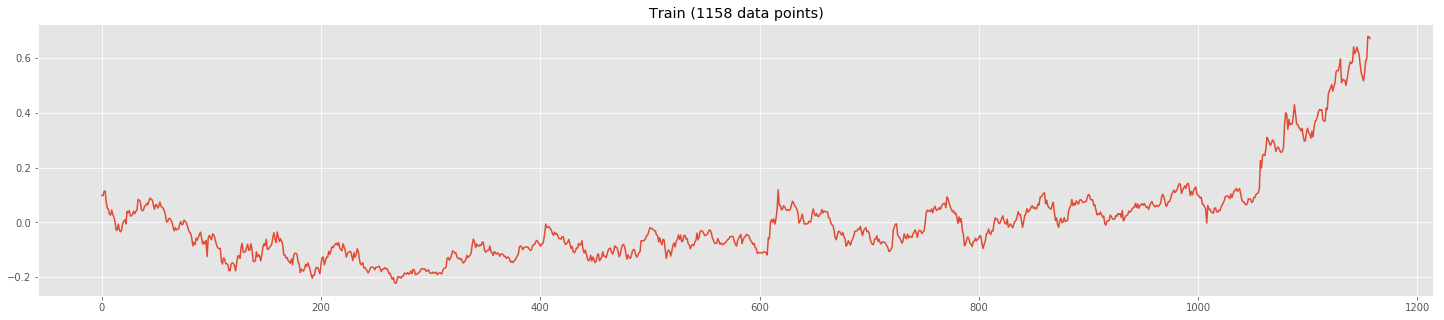

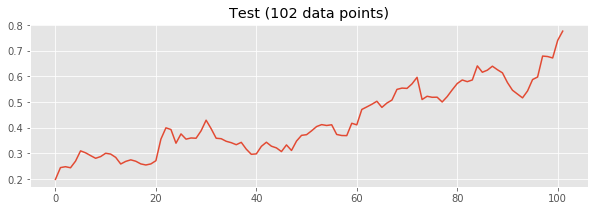

In [91]:
plt.figure(figsize=(25,5))
plt.plot(xTrain[:,0])
plt.title('Train (' +str(len(xTrain))+' data points)')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(xTest[:,0])
plt.title('Test (' +str(len(xTest))+' data points)')
plt.show()

In [92]:
tf.reset_default_graph()

In [94]:
batchX_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_features],name='data_ph')
batchY_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_classes],name='target_ph')

In [95]:
batchX_placeholder

<tf.Tensor 'data_ph_1:0' shape=(?, 3, 4) dtype=float32>

In [96]:
W2 = tf.Variable(initial_value=np.random.rand(state_size,num_classes),dtype=tf.float32)
b2 = tf.Variable(initial_value=np.random.rand(1,num_classes),dtype=tf.float32)

In [97]:
labels_series = tf.unstack(batchY_placeholder, axis=1)

In [98]:
cell = tf.contrib.rnn.BasicLSTMCell(num_units=state_size)

states_series, current_state = tf.nn.dynamic_rnn(cell=cell,inputs=batchX_placeholder,dtype=tf.float32)

In [99]:
states_series = tf.transpose(states_series,[1,0,2])

In [100]:
last_state = tf.gather(params=states_series,indices=states_series.get_shape()[0]-1)
last_label = tf.gather(params=labels_series,indices=len(labels_series)-1)

In [101]:
weight = tf.Variable(tf.truncated_normal([state_size,num_classes]))
bias = tf.Variable(tf.constant(0.1,shape=[num_classes]))

In [102]:
prediction = tf.matmul(last_state,weight) + bias
prediction

<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>

In [103]:
loss = tf.reduce_mean(tf.squared_difference(last_label,prediction))

train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [104]:
loss_list = []
test_pred_list = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            
            batchX = xTrain[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
            batchY = yTrain[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
                
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX.shape,batchX)
            #print('Y',batchX.shape,batchY)
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            #TRAIN!
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list.append(_loss)
            
           
            
            if(batch_idx % 50 == 0):
                print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(len(xTest) - truncated_backprop_length):
        
        testBatchX = xTest[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
        testBatchY = yTest[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))

        
        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list.append(test_pred[-1][0]) #The last one

Epoch 0
Step 0 - Loss: 0.001102
Step 50 - Loss: 0.001457
Step 100 - Loss: 0.000341
Step 150 - Loss: 0.001588
Step 200 - Loss: 0.002598
Step 250 - Loss: 0.009661
Step 300 - Loss: 0.000381
Step 350 - Loss: 0.000152
Epoch 1
Step 0 - Loss: 0.018199
Step 50 - Loss: 0.000453
Step 100 - Loss: 0.000011
Step 150 - Loss: 0.000053
Step 200 - Loss: 0.000183
Step 250 - Loss: 0.004534
Step 300 - Loss: 0.000000
Step 350 - Loss: 0.000303
Epoch 2
Step 0 - Loss: 0.001962
Step 50 - Loss: 0.000007
Step 100 - Loss: 0.000004
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.002824
Step 300 - Loss: 0.000051
Step 350 - Loss: 0.000339
Epoch 3
Step 0 - Loss: 0.000074
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000019
Step 150 - Loss: 0.000075
Step 200 - Loss: 0.000006
Step 250 - Loss: 0.002214
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000318
Epoch 4
Step 0 - Loss: 0.000004
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000034
Step 150 - Loss: 0.000073
Step 200 - Loss: 0.000005
Step 250 - Lo

Step 300 - Loss: 0.000018
Step 350 - Loss: 0.000159
Epoch 77
Step 0 - Loss: 0.000064
Step 50 - Loss: 0.000156
Step 100 - Loss: 0.000002
Step 150 - Loss: 0.000041
Step 200 - Loss: 0.000012
Step 250 - Loss: 0.000482
Step 300 - Loss: 0.000019
Step 350 - Loss: 0.000159
Epoch 78
Step 0 - Loss: 0.000061
Step 50 - Loss: 0.000154
Step 100 - Loss: 0.000001
Step 150 - Loss: 0.000041
Step 200 - Loss: 0.000011
Step 250 - Loss: 0.000476
Step 300 - Loss: 0.000019
Step 350 - Loss: 0.000159
Epoch 79
Step 0 - Loss: 0.000058
Step 50 - Loss: 0.000152
Step 100 - Loss: 0.000001
Step 150 - Loss: 0.000042
Step 200 - Loss: 0.000010
Step 250 - Loss: 0.000469
Step 300 - Loss: 0.000020
Step 350 - Loss: 0.000159
Epoch 80
Step 0 - Loss: 0.000056
Step 50 - Loss: 0.000149
Step 100 - Loss: 0.000001
Step 150 - Loss: 0.000042
Step 200 - Loss: 0.000010
Step 250 - Loss: 0.000463
Step 300 - Loss: 0.000020
Step 350 - Loss: 0.000159
Epoch 81
Step 0 - Loss: 0.000053
Step 50 - Loss: 0.000147
Step 100 - Loss: 0.000001
Step 150

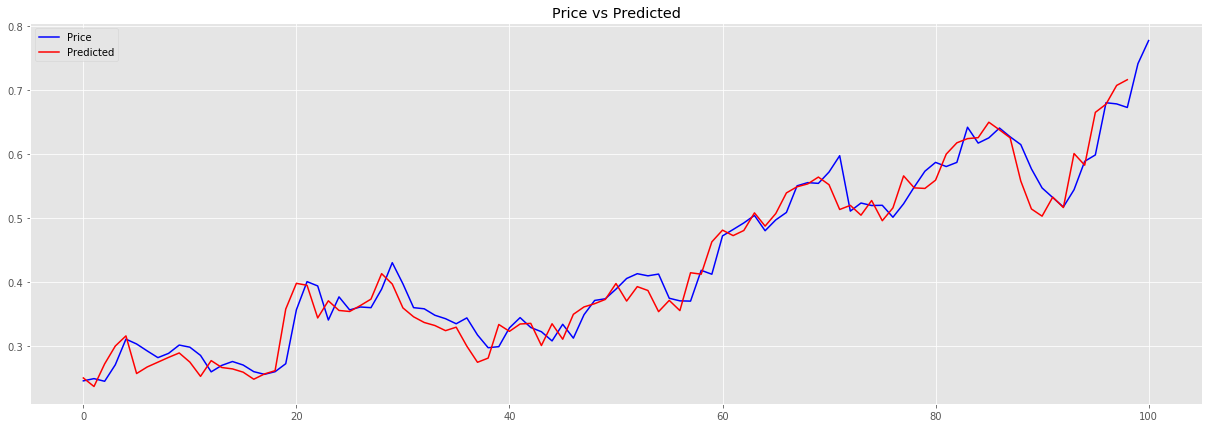

In [105]:
plt.figure(figsize=(21,7))
plt.plot(yTest,label='Price',color='blue')
plt.plot(test_pred_list,label='Predicted',color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()

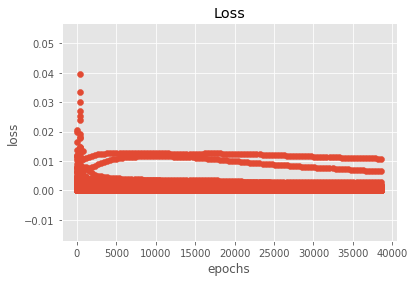

In [106]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Loss')
plt.scatter(x=np.arange(0,len(loss_list)), y=loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()